# Homework 2: YOLO

Credit: Saathvik Selvan, Andrew Goldberg, Tim Xie, Aryan Jain

In lecture, we saw this fully convolutional neural network that was capable of performing object detection with a single forward pass and, as such, was significantly faster than prior R-CNN based approaches. This approach was called YOLO and in this homework, we will implement a basic version of it!

We highly recommend going over the Object Detection lecture before you attempt this homework.

**Please make a copy of this notebook and work on it instead of this notebook. The copy will be owned by you and this will ensure that any changes you make to it will get saved.**

Please also change your Colab runtime to CPU (go to Runtime -> Change Runtime Type -> choose CPU). You should use CPU mode while you are reading through the notebook and debugging and only switch to GPU mode once you are confident enough to start a long model training session.

In [ ]:
!pip install einops

In [ ]:
import time
import os

import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torchvision.transforms import v2 as T
from torchvision.transforms.v2 import functional as TF
from torchvision import models, datasets
from torchvision import tv_tensors

from tqdm.notebook import tqdm

import einops
import numpy as np
from matplotlib import pyplot as plt
from random import randint

import torchvision.datasets as dset
import json
from PIL import Image, ImageDraw

from itertools import product

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Part 1: Loading VOC Dataset

In this homework, we will work with the Pascal VOC dataset. It's a small-scale object detection dataset that was used in the early days for benchmarking object detection models. You can learn more about it [here](http://host.robots.ox.ac.uk/pascal/VOC/).

Before we load in the actual dataset, we specify some important parameters:

`S`: The number of cells we break our image into along the x and y axis (so this gives us an `S x S` grid with $S^2$ cells total).

`B`: The number of detections per cell (we let our model predict up to `B` boxes per cell since it's possible multiple objects are centered in the same cell)

`C`: The number of classes that each object in this dataset could belong to (Pascal VOC has 20 labels)

In [ ]:
S, B, C = 7, 2, 20

The VOC Dataset has the data we need, but not in the right format. So we create our own custom dataset which returns the labels in the right format for us to judge our model predictions against (both the ground truth labels and the model predictions will have the same format).

**What is the format of our ground truth labels and model predictions?**

Each image can be broken into $S^2$ cells (49 in our case), and we predict up to $B$ boxes (2 in our case) that could be centered around each cell.

When we predict a box within a cell, we predict the box center $(x, y)$ within the cell as proportions of the cell width but we also predict the box width ($w$) and height ($h$) as a proportion of the full image size.

We also predict a confidence score for each box (within each cell) which represents how confident our model is that an object is actually present within said box: this will be a number in the range [0, 1] and we will more concretely define "confidence" later.

Finally, we predict the class label, encoded as a vector of probabilities (of length $C$), of the object centered around a cell (if there is any). Note that we are only predicting one class per cell instead of one class per bounding box: this was a design choice made by the authors of YOLO that effectively constrains a cell to detect at most 1 object.

Why would you want to predict multiple boxes per cell if they are gonna belong to the same object/class anyways? The idea is that this makes each box "specialize" in some way (say, one box gets better at predicting bounding boxes that are tall rectangles and another might get better at predicing wide rectangles) so during inference time, we can pick the "best" shaped one (we will talk more about this process later).

So, each time we make a prediction on an image, we predict `B` bounding boxes and a `C`-length vector of probabilities for each cell in our `S x S` grid. Each bounding box has 5 numbers associated with it: in order, these are the confidence score `s` (note the lowercase s here), the bounding box center `x` and `y` (relative to the cell) and bounding width `w` and height `h` (relative to the image). In other words, we predict a `5B + C` dimensional vector for each cell so the final output for a single image will have shape `(S, S, 5B + C)` --- when considering a batch of images, the output for that batch will have shape `(batch_size, S, S, 5B + C)`.

In [ ]:
class VOCDataset(Dataset):
    def __init__(self, orig_dataset, classes, transform=None):
      self.orig_dataset = orig_dataset
      self.classes = classes
      self.transform = transform

    def __len__(self):
        """
        When you inherit from Dataset you always need to specify a __len__ method.
        Otherwise, how would your DataLoader know when to stop!?
        """
        return len(self.orig_dataset)

    def _get_normalised_box(self, idx, obj, img_size: tuple[int, int]):
        """
        The VOCDataset has boxes in an xmin, ymin, xmax, ymax format, but we need our boxes
        to be in the YOLO format which is an (x, y) representing the center and
        the width and height of the box.
        We return the converted box and the cell (x, y) which the box is centered in
        """
        x_min, y_min, x_max, y_max = obj

        cell_width, cell_height = img_size[0] / S, img_size[1] / S

        box_center_x, box_center_y = (x_max - x_min) / 2 + x_min, (y_max - y_min) / 2 + y_min
        cell_num_x, cell_num_y = int(box_center_x // cell_width), int(box_center_y // cell_height)
        assert cell_num_x < S and cell_num_y < S, f"Box is out of bounds!, {idx, x_min, y_min, x_max, y_max, box_center_x, cell_width, box_center_y, cell_height}"
        box_x, box_y = (box_center_x % (cell_width)) / cell_width , (box_center_y % cell_height) / cell_height

        box_w, box_h = (x_max - x_min) / img_size[0], (y_max - y_min) / img_size[1]
        box = torch.tensor([box_x, box_y, box_w, box_h])

        return box, (cell_num_y, cell_num_x)


    def __getitem__(self, idx):
        """
        We need a way to go from an index to the data we want!
        We return a normalized img formatted as a tensor
        And, we want our labels in shape (S, S, 5 * B + C)
        """
        img, label = self.orig_dataset[idx]
        img = T.ToTensor()(img)

        boxes = [[int(obj["bndbox"][i]) for i in ["xmin", "ymin", "xmax", "ymax"]] for obj in label["annotation"]["object"]]
        boxes = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=img.shape[-2:])
        classes = [obj["name"] for obj in label["annotation"]["object"]]

        if self.transform:
            img, boxes = self.transform(img, boxes)

        onehot_ls = torch.eye(len(self.classes))
        one = torch.tensor([1])

        out = torch.zeros((S, S, 5 * B + len(self.classes)))

        bboxes = {}

        for obj_name, box_ in zip(classes, boxes):
            x_min, y_min, x_max, y_max = box_
            if x_min >= x_max or y_min >= y_max:
                continue

            box, (y, x) = self._get_normalised_box(idx, box_, (img.shape[-1], img.shape[-2]))

            detection_zone = out[y][x]

            class_probs = onehot_ls[self.classes.index(obj_name)]
            detection_zone[5*B:] = class_probs

            bbox_id = bboxes.get((y, x), 0)
            if bbox_id < B:
                bboxes[(y, x)] = bbox_id + 1
                for i in range(bbox_id, B):
                    detection_zone[5*i:5*(i+1)] = torch.concat([one, box], dim=-1)

        return img, out

In [ ]:
data_root = '/data/voc'
train_size = 2304 * 4
val_size = 2304

dataset = torchvision.datasets.VOCDetection(
    root=data_root,
    year='2012',
    image_set='trainval',
    download=True,
    transform=None,
)
assert train_size + val_size <= len(dataset), "Trying to sample too many elements!" \
                                              "Please lower the train or validation set sizes."

train_temp_set = torch.utils.data.Subset(dataset, range(train_size))
val_temp_set = torch.utils.data.Subset(dataset, range(train_size, train_size + val_size))

100%|██████████| 2.00G/2.00G [01:38<00:00, 20.2MB/s]


Extracting /data/voc/VOCtrainval_11-May-2012.tar to /data/voc


In [ ]:
image_size = 224

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

train_transform = T.Compose([
    T.Resize((image_size, image_size), antialias=True),
    T.ColorJitter(saturation=0.1, hue=0.1),
    T.RandomHorizontalFlip(),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=0),
    T.Normalize(mean, std)
])

valid_transform = T.Compose([
    T.Resize((image_size, image_size), antialias=True),
    T.Normalize(mean, std)
])

unnormalize = T.Normalize((-mean / std), (1.0 / std))

classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
          'bus', 'car', 'cat', 'chair', 'cow',
          'diningtable', 'dog', 'horse', 'motorbike', 'person',
          'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

train_set = VOCDataset(train_temp_set, classes, train_transform)
val_set = VOCDataset(val_temp_set, classes, valid_transform)

Again, like we did for the CIFAR dataset in HW 2A, let's visualize some of the images in the Pascal VOC dataset.

In [ ]:
def retrieve_bboxes(bboxes):
    boxes_ls, classes_ls, scores_ls = [], [], []

    cell_size = image_size / S

    for sy in range(S):
        for sx in range(S):
            cell = bboxes[sy][sx]
            for b in range(B):
                if cell[5 * b] > 0.0:

                    class_num = torch.argmax(cell[5*B:], dim=-1)
                    class_label = classes[class_num]
                    classes_ls.append(class_label)
                    scores_ls.append(cell[5 * b])

                    y1 = cell_size * (sy + cell[5 * b + 2]) - (image_size * cell[5 * b + 4] / 2)
                    x1 = cell_size * (sx + cell[5 * b + 1]) - (image_size * cell[5 * b + 3] / 2)
                    y2 = y1 + image_size * cell[5 * b + 4]
                    x2 = x1 + image_size * cell[5 * b + 3]

                    xyxy = [x1, y1, x2, y2]

                    boxes_ls.append(xyxy)

    return boxes_ls, classes_ls, scores_ls

def visualize(image, bboxes_ls, classes_ls, scores_ls):
    img = unnormalize(image)
    img = T.Resize((448, 448), antialias=True)(img)
    img = T.ToPILImage()(img)
    draw = ImageDraw.Draw(img)

    for box, class_, score in zip(bboxes_ls, classes_ls, scores_ls):
        box = [i * 448 / image_size for i in box]
        draw.rectangle(box, outline=(255, 0, 0))
        box_text = f" {class_} {score:4.2f} "
        annotation_pos = (box[0], box[1] - 11)
        annotation_box = draw.textbbox(annotation_pos, box_text)
        draw.rectangle(annotation_box, fill=(255, 0, 0), outline=(255, 0, 0))
        draw.text(annotation_pos, box_text, fill=(255, 255, 255))

    display(img)

showing training images and boxes


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


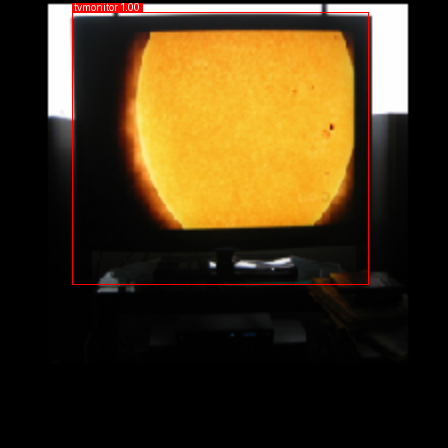

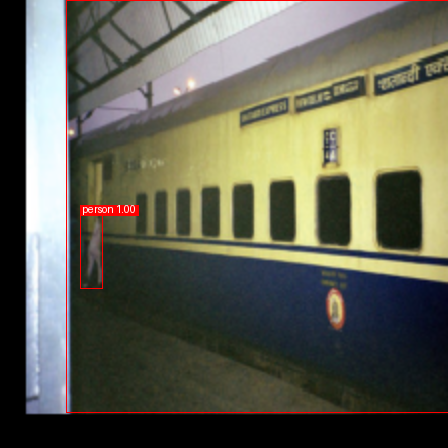

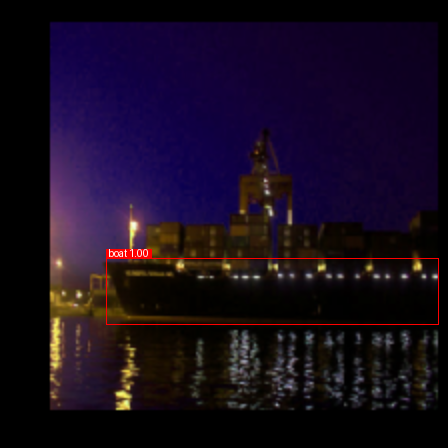

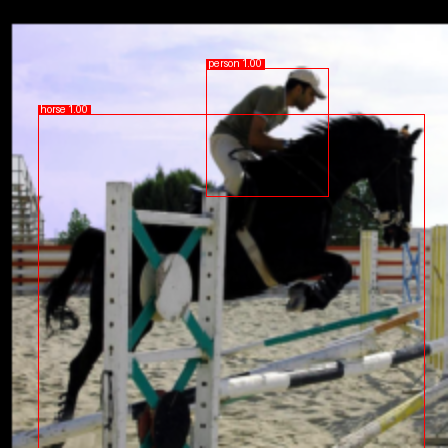

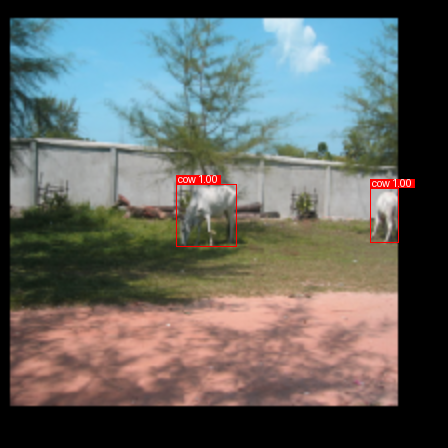

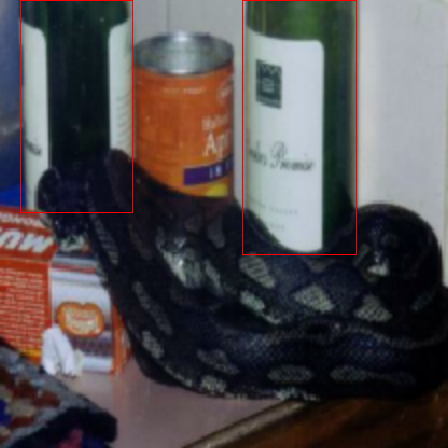

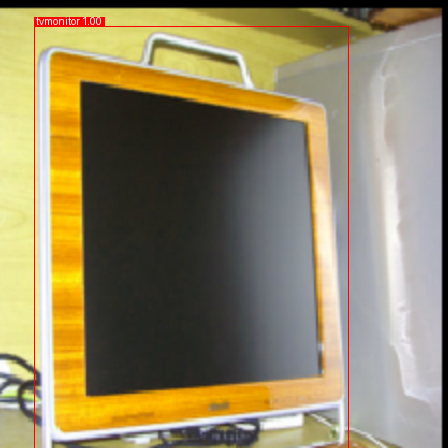

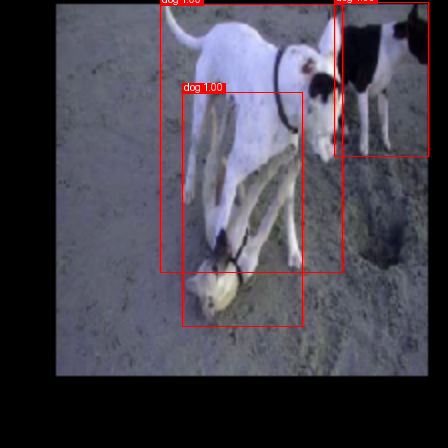

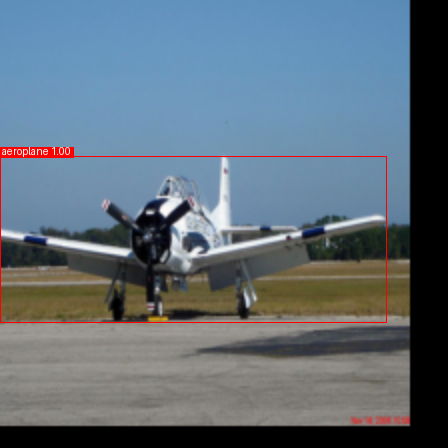

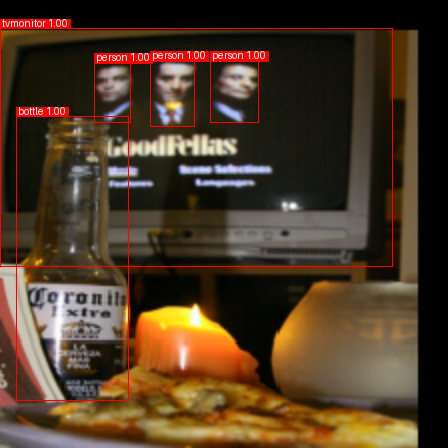

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

print('showing training images and boxes')
for i in range(10):
    images, bboxes = train_set[i]
    bboxes_ls, classes_ls, scores_ls = retrieve_bboxes(bboxes)
    visualize(images, bboxes_ls, classes_ls, scores_ls)

Part 2: YOLO for Object Detection

In this section, we will be implementing the object detection architecture and algorithm used in the You Only Look Once (YOLO) paper. This paper introduced a fully convolutional network that takes in images and simultaneously predicts both bounding boxes and class probabilities, essentially turning object detection into a single regression problem.

**This section is pretty important. Please stop by office hours or post on Ed if you have questions about how "confidence" values work in YOLO.**

Based on the discussion of the data format above, we know that our model will spit out $B$ bounding box predictions for each cell during both training and inference time: if a cell contains an object, we need a way to designate which of those bounding boxes should be picked as the given object's "predictor". During inference time, we will use a technique called non-max suppression (which will be discussed later) but during training time, we will just pick the box that has the highest IOU with its corresponding ground truth bounding box.

This is also how we will define "confidence" in the context of YOLO: formally, the confidence value of a bounding box prediction is the IOU it gets with its corresponding ground truth box. This makes a lot of sense because:
* If there is no ground truth box that corresponds to a bounding box prediction (i.e. this bounding box prediction doesn't really correspond to anything and should be ignored), the IOU will be 0 and we would also like to predict a confidence value of 0 for this box.
* If there is a ground truth box that corresponds to a bounding box prediction, the confidence value will depend on the shape of the box. If
  - the box prediction has a very high overlap with the ground truth, it will achieve a high IOU and thus, we would like to predict a high confidence for this box
  - the box prediction has a low overlap with the ground truth, it will achieve a low IOU and we would also to predict a lower confidence value for this box

In a sense, this is encouraging a bounding box to predict its own IOU. This will be useful during inference time since we can then only pick boxes with high confidence values since they should hopefully correspond to more accurate predictions.

During training time, we would only like to penalize the bounding box that was designated as the "predictor" for an object among all predicted bounding box candidates within a cell and ignore the contribution of all other "frivolous" boxes to the YOLO loss objective. As such, we define a `box_mask` tensor of shape `(S, S, B)` such that `box_mask[i, j, k] = 1` if the `k`th bounding box in cell `(i, j)` is responsible for predicting an object and 0 otherwise.

Similarly, we can also define a `cell_mask` tensor of shape `(S, S)` such that `cell_mask[i, j] = 1` if cell `(i, j)` contains an object that is centered within it and, consequently, will also pick a designated "predictor" among its bounding box predictions for said object.

Clearly, we need a way to quickly compute the IOU between the predicted bounding boxes and the ground truth bounding boxes. Here is a helper function that we implemented for you that takes care of this computation!

You should read through the function below and try to understand it to the best of your ability. It contains certain hints for parts of the homework that you will have to implement yourself.

In [ ]:
def batched_iou(preds, labels):
    """
    Compute the pairwise IOU between the predicted bounding boxes and the ground truth bounding boxes for each cell.

    param: preds is tensor of shape (N, S, S, 5B + C)
    param: labels is a tensor of shape (N, S, S, 5B + C)

    returns: tensor of shape (N, S, S, B, B) containing the pairwise IOU between the predicted bounding boxes and the ground truth bounding boxes for each cell
    """
    N = labels.shape[0]

    x_labels, x_preds = labels[:, :, :, 1:5*B:5], preds[:, :, :, 1:5*B:5]
    y_labels, y_preds = labels[:, :, :, 2:5*B:5], preds[:, :, :, 2:5*B:5]
    w_labels, w_preds = labels[:, :, :, 3:5*B:5], preds[:, :, :, 3:5*B:5]
    h_labels, h_preds = labels[:, :, :, 4:5*B:5], preds[:, :, :, 4:5*B:5]

    cell_size = image_size / S
    # retrieve the coordinates of the bounding box rectangles for the labels
    x1_labels = cell_size * (x_labels + einops.repeat(torch.arange(S, device=labels.device), "S2 -> N S1 S2 B", N=N, S1=S, B=B)) - (image_size * w_labels / 2)
    y1_labels = cell_size * (y_labels + einops.repeat(torch.arange(S, device=labels.device), "S1 -> N S1 S2 B", N=N, S2=S, B=B)) - (image_size * h_labels / 2)
    x2_labels = x1_labels + image_size * w_labels
    y2_labels = y1_labels + image_size * h_labels
    # retrieve the coordinates of the bounding box rectangles for the predictions
    x1_preds = cell_size * (x_preds + einops.repeat(torch.arange(S, device=labels.device), "S2 -> N S1 S2 B", N=N, S1=S, B=B)) - (image_size * w_preds / 2)
    y1_preds = cell_size * (y_preds + einops.repeat(torch.arange(S, device=labels.device), "S1 -> N S1 S2 B", N=N, S2=S, B=B)) - (image_size * h_preds / 2)
    x2_preds = x1_preds + image_size * w_preds
    y2_preds = y1_preds + image_size * h_preds

    # compute the top left and bottom right corners of the rectangles
    tl_labels = torch.stack([x1_labels, y1_labels], dim=-1)
    br_labels = torch.stack([x2_labels, y2_labels], dim=-1)
    tl_preds = torch.stack([x1_preds, y1_preds], dim=-1)
    br_preds = torch.stack([x2_preds, y2_preds], dim=-1)

    # Largest top-left corner and smallest bottom-right corner give the intersection
    tl = torch.max(
        einops.repeat(tl_preds,  "N S1 S2 B1 D -> N S1 S2 B1 B2 D", B2=B),        # (N, S, S, B, 1, 2) -> (N, S, S, B, B, 2)
        einops.repeat(tl_labels, "N S1 S2 B2 D -> N S1 S2 B1 B2 D", B1=B)         # (N, S, S, 1, B, 2) -> (N, S, S, B, B, 2)
    )
    br = torch.min(
        einops.repeat(br_preds,  "N S1 S2 B1 D -> N S1 S2 B1 B2 D", B2=B),        # (N, S, S, B, 1, 2) -> (N, S, S, B, B, 2)
        einops.repeat(br_labels, "N S1 S2 B2 D -> N S1 S2 B1 B2 D", B1=B)         # (N, S, S, 1, B, 2) -> (N, S, S, B, B, 2)
    )

    intersection_sides = torch.clamp(br - tl, min=0.0)
    intersection = intersection_sides[..., 0] * intersection_sides[..., 1]       # (N, S, S, B, B)

    area_preds = (w_preds * image_size) * (h_preds * image_size)
    area_preds = einops.repeat(area_preds, "N S1 S2 B1 -> N S1 S2 B1 B2", B2=B)

    area_labels = (w_labels * image_size) * (h_labels * image_size)
    area_labels = einops.repeat(area_labels, "N S1 S2 B2 -> N S1 S2 B1 B2", B1=B)

    union = area_labels + area_preds - intersection

    # Add a small non-zero constant to avoid division-by-zero errors
    union += 1e-6

    return intersection / union

We also need a way to compute `cell_mask` and `box_mask` using the IOU between the ground truth and predicted bounding boxes: among all the bounding box predictions for a cell, we designate a box as a "predictor" for an object if it achieves the highest IOU with the corresponding ground truth box.

Again, we will provide helper functions that create these masks using the ground truth labels and model predictions.

In [ ]:
def create_masks(preds, labels):
    """
    Create the cell and box masks based on the IOU.

    param: preds is tensor of shape (N, S, S, 5B + C)
    param: labels is a tensor of shape (N, S, S, 5B + C)
    """
    N = labels.shape[0]

    iou = batched_iou(preds, labels) # (N, S, S, B, B)
    preds = preds[:, :, :, :5*B]
    labels = labels[:, :, :, :5*B]

    # iou[..., i, j] gives the IOU between ith prediction box and jth label box
    # take the max over all label boxes to get the cloest label box to a prediction box
    iou, _ = torch.max(iou, dim=-1) # (N, S, S, B)

    # 1 if bounding box is "responsible" for predicting the object
    responsible = torch.zeros(N, S, S, B, device=labels.device).scatter_(-1, torch.argmax(iou, dim=-1, keepdim=True), value=1)

    # 1 if cell contains an object and otherwise
    conf_labels = labels[:, :, :, 0::5] > 0.0
    cell_mask = conf_labels[..., 0]

    # 1 if box contains an object and is responsible for it
    box_mask = responsible * conf_labels

    return iou, cell_mask, box_mask

Now that we have uniquely formulated the object detection problem, we will introduce the loss function that YOLO optimizes. It has three components and we will step through each one:

**Classification Loss**: If a cell contains an object, we take the squared error between the class probabiities the model predicts for said cell vs the ground truth labels (which will be a one-hot vector). We add up this squared error for all cells that contain an object. Mathematically, this *classification loss* is given by
$$
l_{\text{classification}} = \sum_{i=0}^{S-1} \sum_{j=0}^{S-1} \mathbb 1_{ij}^{\text{obj}} \sum_{c \in \text{classes}} (p_{ij}(c) - \hat{p}_{ij}(c))^2
$$
where
* $\mathbb 1_{ij}^{\text{obj}}$ is $1$ if cell $(i, j)$ should detect an object, otherwise $0$ --- this is precisely the value given by `cell_mask[i, j]`
* $\hat{p}_{ij}(c)$ is the class probability, predicted by the model, of the object in cell $(i, j)$ belonging to class $c$
* $p_{ij}(c)$ is the class probability, according to the ground truth label, of the object in cell $(i, j)$ belonging to class $c$

In [ ]:
def l_classification(preds, labels, cell_mask):
    """
    Compute the classification loss as described above.

    param: preds is tensor of shape (N, S, S, 5B + C)
    param: labels is a tensor of shape (N, S, S, 5B + C)
    param: cell_mask is a tensor of shape (N, S, S)

    Here N is the batch size.
    Refer to the discussion above for more info on the prediction/label format.

    Along the last dimension for both tensors (i.e. for a specific cell of a specific image):
    1. the first 5B elements can be divided into B groups of 5 elements each, with each group representing a bounding box for a particular class
       in particular, each 5 element tuple, in order, will be the (confidence, x, y, w, h) for a bounding box
    2. the last C elements are class probabilities

    Note: for the ground truth labels, the class probabilities will be one-hot encoded.
    """
    # Extract class probabilities from labels (one-hot encoded)
    class_labels = labels[..., 5 * B:]  # (N, S, S, C)

    # Extract class probabilities from predictions
    class_preds = preds[..., 5 * B:]  # (N, S, S, C)

    # Compute squared error loss for class probabilities
    class_l = (class_preds - class_labels) ** 2  # (N, S, S, C)

    # Sum over class probabilities to get per-cell loss
    class_l = torch.sum(class_l, dim=-1)  # (N, S, S)

    # Apply cell_mask to only consider cells that contain objects
    class_l = class_l * cell_mask  # (N, S, S)

    # Sum over all grid cells and batch
    return torch.sum(class_l)

**Localisation Loss**: If a bounding box is responsible for detecting an object, we take the squared error of its position and size predictions with respect to the true bounding box in the ground truth label. Remember that the problem of predicting an object's bounding box size and position is also known as object localization. As such, this loss component is also called *localization loss* and is given mathematically by:
$$
\begin{aligned}
l_{\text{localisation}} &= \sum_{i=0}^{S - 1} \sum_{j=0}^{S - 1} \sum_{k=0}^{B - 1} \mathbb 1_{ijk}^{\text{obj}} \left[(x_{ijk} - \hat{x}_{ijk})^2 + (y_{ijk} - \hat{y}_{ijk})^2 + \left( \sqrt{w_{ijk}} - \sqrt{\hat{w}_{ijk}} \right)^2 + \left( \sqrt{h_{ijk}} - \sqrt{\hat{h}_{ijk}} \right)^2 \right]
\end{aligned}
$$
where
* $\mathbb 1_{ijk}^{\text{obj}}$ is $1$ if the $k$th boundary box in cell $(i, j)$ is responsible for detecting the object, otherwise $0$ --- this is precisely the value given by `box_mask[i, j, k]`
* $(\hat{x}_{ijk}, \hat{y}_{ijk}, \hat{w}_{ijk}, \hat{h}_{ijk})$ are the center coordinates and spatial dimensions of the $k$th bounding box in cell $(i, j)$ according to the model predictions
* $(x_{ijk}, y_{ijk}, w_{ijk}, h_{ijk})$ are the center coordinates and spatial dimensions of the $k$th bounding box in cell $(i, j)$ according to the ground truth labels

In [ ]:
def l_localization(preds, labels, box_mask):
    """
    Compute the localization loss as described above.

    param: preds is tensor of shape (N, S, S, 5B + C)
    param: labels is a tensor of shape (N, S, S, 5B + C)
    param: box_mask is a tensor of shape (N, S, S, B)

    Here N is the batch size.
    Refer to the discussion above for more info on the prediction/label format.

    Along the last dimension for both tensors (i.e. for a specific cell of a specific image):
    1. the first 5B elements can be divided into B groups of 5 elements each, with each group representing a bounding box for a particular class
       in particular, each 5 element tuple, in order, will be the (confidence, x, y, w, h) for a bounding box
    2. the last C elements are class probabilities
    """
    x_labels = labels[..., 1:5*B:5]  # (N, S, S, B)
    x_preds = preds[..., 1:5*B:5]  # (N, S, S, B)
    x_l = (x_preds - x_labels) ** 2  # Squared error

    # Extract y-coordinates
    y_labels = labels[..., 2:5*B:5]  # (N, S, S, B)
    y_preds = preds[..., 2:5*B:5]  # (N, S, S, B)
    y_l = (y_preds - y_labels) ** 2  # Squared error

    # Extract widths
    w_labels = labels[..., 3:5*B:5]  # (N, S, S, B)
    w_preds = preds[..., 3:5*B:5]  # (N, S, S, B)
    w_l = (torch.sqrt(w_preds + 1e-6) - torch.sqrt(w_labels + 1e-6)) ** 2  # Squared error on square root

    # Extract heights
    h_labels = labels[..., 4:5*B:5]  # (N, S, S, B)
    h_preds = preds[..., 4:5*B:5]  # (N, S, S, B)
    h_l = (torch.sqrt(h_preds + 1e-6) - torch.sqrt(h_labels + 1e-6)) ** 2  # Squared error on square root

    # Compute total localization loss
    box_l = x_l + y_l + w_l + h_l  # (N, S, S, B)

    # Apply the box_mask (only consider responsible bounding boxes)
    box_l = box_l * box_mask  # (N, S, S, B)

    # Sum across all bounding boxes, grid cells, and batch
    return torch.sum(box_l)

**Confidence Loss**: We take the squared error between the confidence of each predicted box and its target confidence (this target is the IOU said box achieves with the corresponding ground truth bounding box if the box is designated as a predictor and 0 otherwise).

We compute two loss terms: the first term only contains the squared errors of the predicted boxes that are designated as responsible for bounding an object and the second term contains everything else. We return two terms because we want to weight the contribution of each term to the overall loss differently.
$$
\begin{aligned}
l_{\text{confidence_obj}} &= \sum_{i=0}^{S - 1} \sum_{j = 0}^{S - 1} \sum_{k=0}^B \mathbb 1_{ijk}^{\text{obj}} (s_{ijk} - \hat{s}_{ijk})^2 \\
l_{\text{confidence_no_obj}} &= \sum_{i=0}^{S - 1} \sum_{j = 0}^{S - 1} \sum_{k=0}^B \mathbb 1_{ijk}^{\text{no_obj}} (s_{ijk} - \hat{s}_{ijk})^2
\end{aligned}
$$
where
* $\hat{s}_{ijk}$ is the box confidence score of the $k$th box in cell $(i, j)$ and $s_{ijk}$ is the IOU it is trying to predict, as mentioned at the beginning of this section
* $\mathbb 1_{ijk}^{\text{obj}}$ is $1$ if the $k$th boundary box in cell $(i, j)$ is responsible for detecting the object, otherwise $0$ --- this is precisely the value given by `box_mask[i, j, k]`
* $\mathbb 1_{ij}^{\text{no_obj}} = 1 - \mathbb 1_{ij}^{\text{obj}}$ is the complement of $1_{ij}^{\text{obj}}$



In [ ]:
def l_confidence(preds, ious, box_mask):
    """
    Compute both confidence loss terms as described above.

    param: preds is tensor of shape (N, S, S, 5B + C)
    param: ious is a tensor of shape (N, S, S, B)
    param: box_mask is a tensor of shape (N, S, S, B)

    Here N is the batch size.
    Refer to the discussion above for more info on the prediction/label format.

    Along the last dimension for both tensors (i.e. for a specific cell of a specific image):
    1. the first 5B elements can be divided into B groups of 5 elements each, with each group representing a bounding box for a particular class
       in particular, each 5 element tuple, in order, will be the (confidence, x, y, w, h) for a bounding box
    2. the last C elements are class probabilities
    """
    # Extract confidence scores from predictions
    s_preds = preds[..., 0:5*B:5]  # (N, S, S, B)

    # Compute squared error for responsible boxes (box with highest IOU)
    s_l_obj = (s_preds - ious) ** 2  # (N, S, S, B)

    # Compute squared error for background boxes (should predict confidence = 0)
    s_l_no_obj = (s_preds - torch.zeros_like(ious)) ** 2  # (N, S, S, B)

    # Apply masks
    s_l_obj = s_l_obj * box_mask  # Loss only for responsible boxes
    s_l_no_obj = s_l_no_obj * (1 - box_mask)  # Loss only for non-responsible boxes

    # Sum across all grid cells, bounding boxes, and batch
    return torch.sum(s_l_obj), torch.sum(s_l_no_obj)

We can now compute the overall loss as the weighted sum of each of the loss terms above:
$$
\begin{aligned}
l = l_{\text{classification}} + \lambda_{\text{coord}} l_{\text{localization}} + l_{\text{confidence_obj}} + \lambda_{\text{no_obj}}l_{\text{confidence_no_obj}}
\end{aligned}
$$
where
* $\lambda_{\text{coord}}$ is some hyperparameter that scales the contribution of the localization loss to the overall loss term. In this case, we set it to $5$ to **increase** the weight of this loss term since predicting accurate bounding box coordinates is very important in object detection.

* $\lambda_{\text{no_obj}}$ is used to **decrease** the weight when detecting the background (i.e. boxes not resposible for predicting an object) instead of an object

We will also return each of the 3 loss components above so we can log them during training.

In [ ]:
def yolo_loss(preds, labels, lambda_coord=5, lambda_no_obj=0.5):
    with torch.no_grad():
        ious, cell_mask, box_mask = create_masks(preds, labels)

    class_l = l_classification(preds, labels, cell_mask)
    local_l = lambda_coord * l_localization(preds, labels, box_mask)
    conf_l_obj, conf_l_no_obj = l_confidence(preds, ious, box_mask)
    conf_l = conf_l_obj + lambda_no_obj * conf_l_no_obj

    return class_l + local_l + conf_l, class_l, local_l, conf_l

Cool! Now that we have the YOLO objective defined, let's also go ahead and define our standard training loop that you have seen in HW 2A and HW 1.

In [ ]:
def eval(model, criterion, loader):
    total_overall_loss = 0
    total_class_loss = 0
    total_local_loss = 0
    total_conf_loss = 0

    model = model.to(device)
    model.eval()

    with torch.no_grad():
        for imgs, labels in tqdm(loader, leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            overall_loss, class_loss, local_loss, conf_loss = criterion(outputs, labels)
            total_overall_loss += overall_loss.item()
            total_class_loss += class_loss.item()
            total_local_loss += local_loss.item()
            total_conf_loss += conf_loss.item()
    total_items = len(loader.dataset)
    return total_overall_loss / total_items, total_class_loss / total_items, total_local_loss / total_items, total_conf_loss / total_items


def train(model, train_loader, val_loader, num_epochs, criterion, optimizer, path=None, scheduler=None):
    print('beginning to train model')
    if path and not os.path.exists(path):
        os.makedirs(path)

    model = model.to(device)

    best_val_loss = float('inf')

    for epoch in tqdm(range(1, num_epochs + 1)):
        model.train()
        total_overall_loss = 0
        total_class_loss = 0
        total_local_loss = 0
        total_conf_loss = 0
        start_time = time.perf_counter()

        for i, (inputs, labels) in enumerate(tqdm(train_loader, leave=False)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            overall_loss, class_loss, local_loss, conf_loss = criterion(outputs, labels)
            overall_loss.backward()
            optimizer.step()
            total_overall_loss += overall_loss.item()
            total_class_loss += class_loss.item()
            total_local_loss += local_loss.item()
            total_conf_loss += conf_loss.item()

        if path:
            torch.save(model.state_dict(), f'{path}/model_ep_{epoch:02d}.pth')

        end_time = time.perf_counter()
        duration = end_time - start_time

        total_items = len(train_loader.dataset)
        train_overall_loss = total_overall_loss / total_items
        train_class_loss = total_class_loss / total_items
        train_local_loss = total_local_loss / total_items
        train_conf_loss = total_conf_loss / total_items
        valid_overall_loss, valid_class_loss, valid_local_loss, valid_conf_loss = eval(model, criterion, val_loader)

        if valid_overall_loss < best_val_loss:
            best_val_loss = valid_overall_loss
            if path:
                torch.save(model.state_dict(), f'{path}/best_model.pth')

        current_lr = optimizer.param_groups[0]['lr']

        if scheduler and current_lr > 1e-4:
            scheduler.step()

        print(f'epoch {epoch:2}',
              f'time: {duration:.3f}',
              f'lr: {current_lr:.3e}',
              '\n',
              f'train loss (overall): {train_overall_loss:08.4f}',
              f'valid loss (overall): {valid_overall_loss:08.4f}',
              '\n',
              f'train loss (class):   {train_class_loss:08.4f}',
              f'valid loss (class):   {valid_class_loss:08.4f}',
              '\n',
              f'train loss (local):   {train_local_loss:08.4f}',
              f'valid loss (local):   {valid_local_loss:08.4f}',
              '\n',
              f'train loss (conf):    {train_conf_loss:08.4f}',
              f'valid loss (conf):    {valid_conf_loss:08.4f}')

This is where we define the actual YOLO architecture. Recall from the Deep Learning 3 and CNN lectures that it is possible to leverage pre-trained convolutional neural networks for their learned representations when working on a new computer vision task. This is actually a pretty common practice in object detection where you leverage the representations learned by an image classification model. We call this pre-trained model the `feature backbone` for our object detection model since we use it to extract relevant features from an input image. This is the first example of transfer learning you have seen in this course.

These features are then passed into what we call a `task-specific head`: this is the set of learnable layers that maps the pre-trained features from the feature backbone to the output for our downstream task. In the cell below, we define the task-specific head for our object detection model, which will just be a bunch of convolutional layers followed by a couple of linear layers whose output is then reshaped to the data format we described above. This head, combined with the feature backbone, comprises the entire YOLO model.


YOLO has undergone many iterations over the years but all of them use some sort of feature backbone and object-detection head (the differences lie in how these backbones/heads are implemented and trained).
For more information on YOLO and its later iterations, check out this really cool and detailed [blog post](https://jonathan-hui.medium.com/real-time-object-detection-with-yolo-yolov2-28b1b93e2088#:~:text=YOLO%20uses%20sum%2Dsquared%20error,box%20and%20the%20ground%20truth).

In [ ]:
class YOLO(nn.Module):
    def __init__(self, backbone, backbone_channels):
        """
        We take as input some feature backbone whose features are passed
        into the custom layers we define below.

        The output of this network should be a tensor of shape (S, S, 5B + C)
        so we train a linear layer that outputs a tensor of shape S * S * (5B + C)
        instead. We then reshape it at the end.
        """
        X = S * S * (5 * B + C)

        super().__init__()
        self.backbone = backbone

        self.conv1 = nn.Conv2d(backbone_channels, 512, 3, 1, 1)
        self.conv2 = nn.Conv2d(512, 512, 3, 1, 1)
        self.conv3 = nn.Conv2d(512, 512, 3, 1, 1)
        self.conv4 = nn.Conv2d(512, 512, 3, 1, 1)

        self.flatten = nn.Flatten()
        self.unflatten = nn.Unflatten(1, (S, S, 5 * B + C))
        self.linear1 = nn.Linear(512 * (image_size // 32) ** 2, 4096)
        self.linear2 = nn.Linear(4096, X)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.backbone(x)
        x = F.leaky_relu(self.conv1(x), 0.1)
        x = F.leaky_relu(self.conv2(x), 0.1)
        x = F.leaky_relu(self.conv3(x), 0.1)
        x = F.leaky_relu(self.conv4(x), 0.1)
        x = self.flatten(x)
        x = F.leaky_relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.unflatten(x)
        x = F.sigmoid(x)

        return x

We will use a ResNet-50 pre-trained on ImageNet for our feature backbone. We could use the ResNet backbone that we trained ourselves on CIFAR-10 in HW 2A, but it will likely not yield very high quality features. Remember that large models trained on large and diverse datasets tend to learn more generalizable and useful features (the ImageNet dataset contains 1.3M images distributed across 1000 semantic categories while the CIFAR-10 dataset only contains 50,000 images distributed across 10 classes). That said, after you have finished this assignment, you could give your custom ResNet model from HW 2A a shot and see how it's performance compares against the ImageNet pre-trained backbone!

Just like `torchvision` stores a bunch of popular CV datasets that can be downloaded as necessary, it also the hub to many popular CNN architectures and their pre-trained weights. We will use it to download the pre-trained ResNet model mentioned above.

In [ ]:
resnet = models.resnet50(weights='DEFAULT')
resnet_channels = resnet.fc.in_features
resnet = torch.nn.Sequential(*list(resnet.children())[:-2])

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 158MB/s]


Now define the model and print out its summary. We will use `torchsummary` (we could also use another module called `torchinfo`) which is a pretty nifty tool that prints out the shape of your input as it traverses through your neural network. This can be a very useful debugging tool and we use it ensure that the model input and output shapes match up with what we expect. For example, if we pass a `3 x 224 x 224` image into our model, we can see that the final output will have a shape of `7 x 7 x 30`, which is precisely what we want!

In [ ]:
yolonet = YOLO(resnet, resnet_channels)
yolonet = yolonet.to(device)
summary(yolonet, (3, 224, 224)) # Each (unbatched) input to the model will be a 3 x 224 x 224 image

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

Note that `torchsummary` also tells you how big your model is. For example, we can see that the YOLO model we defined has 148 million parameters: this is a massive model! Turns out most of these parameters come from the 2 linear layers at the end. However, as you might have learned from HW 2A, this is not completely surprising to us; convolutional layers don't have too many parameters because of their inherent weight sharing.

Now, we can finally start training! Feel free to change the hyperparameters down below but we don't think you will need to.

In [ ]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

In [ ]:
num_epochs = 15
criterion = yolo_loss
optimizer = optim.Adam(yolonet.parameters(), lr=1e-4)

Once you are confident that you implemented the loss functions above correctly, pleast switch to a GPU runtime. While you are debugging your implementation, we would suggest sticking to a CPU runtime so you don't use up your GPU quotas without even getting a change to properly train your model.

A single epoch should take roughly ~3 minutes on the GPU Colab provides. By default, we have set the number of epochs to 30 so it will take around 1 hour 30 minutes to train this model. That said, you can probably reduce the number of epochs down to, say, 15-20, and still get a good enough model to pass this homework's threshold.

In [ ]:
train(yolonet, train_loader, val_loader, num_epochs, criterion, optimizer, 'checkpoints_yolo')

beginning to train model


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

epoch  1 time: 146.102 lr: 1.000e-04 
 train loss (overall): 006.2378 valid loss (overall): 005.2364 
 train loss (class):   002.5501 valid loss (class):   002.3118 
 train loss (local):   002.9950 valid loss (local):   002.4552 
 train loss (conf):    000.6927 valid loss (conf):    000.4694


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

epoch  2 time: 158.361 lr: 1.000e-04 
 train loss (overall): 004.8994 valid loss (overall): 004.9690 
 train loss (class):   002.0350 valid loss (class):   002.1502 
 train loss (local):   002.4107 valid loss (local):   002.3112 
 train loss (conf):    000.4536 valid loss (conf):    000.5076


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

epoch  3 time: 144.474 lr: 1.000e-04 
 train loss (overall): 004.4971 valid loss (overall): 004.6247 
 train loss (class):   001.8321 valid loss (class):   002.0196 
 train loss (local):   002.1958 valid loss (local):   002.0958 
 train loss (conf):    000.4692 valid loss (conf):    000.5094


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

epoch  4 time: 152.420 lr: 1.000e-04 
 train loss (overall): 004.0831 valid loss (overall): 004.3254 
 train loss (class):   001.7148 valid loss (class):   001.9003 
 train loss (local):   001.9076 valid loss (local):   001.9022 
 train loss (conf):    000.4607 valid loss (conf):    000.5229


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

epoch  5 time: 149.671 lr: 1.000e-04 
 train loss (overall): 003.7811 valid loss (overall): 004.1151 
 train loss (class):   001.6001 valid loss (class):   001.7747 
 train loss (local):   001.7269 valid loss (local):   001.7809 
 train loss (conf):    000.4541 valid loss (conf):    000.5595


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

epoch  6 time: 161.949 lr: 1.000e-04 
 train loss (overall): 003.5227 valid loss (overall): 003.9144 
 train loss (class):   001.4398 valid loss (class):   001.6115 
 train loss (local):   001.6274 valid loss (local):   001.7618 
 train loss (conf):    000.4554 valid loss (conf):    000.5411


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

epoch  7 time: 151.861 lr: 1.000e-04 
 train loss (overall): 003.2913 valid loss (overall): 003.7065 
 train loss (class):   001.2903 valid loss (class):   001.4898 
 train loss (local):   001.5423 valid loss (local):   001.7175 
 train loss (conf):    000.4587 valid loss (conf):    000.4992


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

epoch  8 time: 157.766 lr: 1.000e-04 
 train loss (overall): 003.1082 valid loss (overall): 003.5786 
 train loss (class):   001.1730 valid loss (class):   001.3868 
 train loss (local):   001.4838 valid loss (local):   001.6387 
 train loss (conf):    000.4514 valid loss (conf):    000.5530


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

epoch  9 time: 155.873 lr: 1.000e-04 
 train loss (overall): 002.9228 valid loss (overall): 003.4823 
 train loss (class):   001.0722 valid loss (class):   001.3194 
 train loss (local):   001.4039 valid loss (local):   001.6403 
 train loss (conf):    000.4467 valid loss (conf):    000.5225


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

epoch 10 time: 146.177 lr: 1.000e-04 
 train loss (overall): 002.7752 valid loss (overall): 003.2872 
 train loss (class):   000.9685 valid loss (class):   001.2056 
 train loss (local):   001.3618 valid loss (local):   001.5965 
 train loss (conf):    000.4449 valid loss (conf):    000.4851


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

epoch 11 time: 150.057 lr: 1.000e-04 
 train loss (overall): 002.6710 valid loss (overall): 003.1922 
 train loss (class):   000.8963 valid loss (class):   001.1376 
 train loss (local):   001.3234 valid loss (local):   001.5590 
 train loss (conf):    000.4513 valid loss (conf):    000.4957


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

epoch 12 time: 152.856 lr: 1.000e-04 
 train loss (overall): 002.5669 valid loss (overall): 003.1774 
 train loss (class):   000.8272 valid loss (class):   001.0963 
 train loss (local):   001.2867 valid loss (local):   001.5553 
 train loss (conf):    000.4531 valid loss (conf):    000.5259


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

epoch 13 time: 150.741 lr: 1.000e-04 
 train loss (overall): 002.4715 valid loss (overall): 003.1148 
 train loss (class):   000.7688 valid loss (class):   001.0570 
 train loss (local):   001.2549 valid loss (local):   001.5860 
 train loss (conf):    000.4478 valid loss (conf):    000.4718


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

epoch 14 time: 149.210 lr: 1.000e-04 
 train loss (overall): 002.3607 valid loss (overall): 003.0579 
 train loss (class):   000.7092 valid loss (class):   001.0253 
 train loss (local):   001.2031 valid loss (local):   001.5194 
 train loss (conf):    000.4484 valid loss (conf):    000.5133


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

epoch 15 time: 149.155 lr: 1.000e-04 
 train loss (overall): 002.2959 valid loss (overall): 003.0609 
 train loss (class):   000.6632 valid loss (class):   001.0035 
 train loss (local):   001.1801 valid loss (local):   001.5294 
 train loss (conf):    000.4526 valid loss (conf):    000.5280


# Part 3: Non-Max Suppression




Before we visualize our model's predictions, let's reload the best checkpoint.

In [ ]:
yolonet.load_state_dict(torch.load('./checkpoints_yolo/best_model.pth'))

<ipython-input-22-81de3fb91986>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  yolonet.load_state_dict(torch.load('./checkpoints_yolo/best_model.pth'))


<All keys matched successfully>

When we visualize our model's predictions, we will use a technique called non-max supression. Remember that a model will predict up to $S \times S \times B = S^2B$ boxes for a single image: certainly not all of them will contain an object! We could try to filter out some boxes based on their confidence value.
However, how do we choose a confidence threshold? There will likely be multiple boxes on each object if our confidence threshold is too low. On the other hand, if our confidence threshold is too high then some objects won't even be found.

Non-max supression solves this problem. First we filter by setting a low(ish) confidence threshold to get most of the boxes which are around some kind of object (but we still have too many boxes and some boxes will be more or less accurate than others). Now, our goal is to get rid of duplicate boxes around an object. Then we apply non-max supression as follows:

Start with the box of highest confidence. Compute the IOU of that box with all other boxes. If the IOU is above some threshold, eliminate that box. Continue to the next highest box confidence and repeat.

This algorithm gets rid of similar boxes leaving behind only the highest confidence box for each object. Fortunately, `torchvision` already has a function that performs this process for us and we will use it to generate model visualizations on the validation set below.

In the cell below, we first manually filter out all boxes with a confidence less than `conf_threshold` (which has a value of 0.2) and then perform NMS with an IOU threshold of `nms_threshold` (which currently has a value of 0.5). We were able to get decent visualizations with these thresholds but feel free to change them as you see fit!

In [ ]:
conf_threshold = 0.2
nms_threshold = 0.5

In [ ]:
def nms_visualize(model, loaded):
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        imgs, _ = loaded
        imgs = imgs.to(device)

        outputs = model(imgs)
    img, label = imgs[0], outputs[0]

    model.train()

    filtered_boxes, filtered_classes, filtered_scores = nms_best(label)

    visualize(img, filtered_boxes, filtered_classes, filtered_scores)

def nms_best(preds):
    preds = preds.to("cpu").reshape((S, S, 5 * B + C))

    boxes_ls, classes_ls, scores_ls = [], [], []

    for sy in range(S):
        for sx in range(S):
            cell = preds[sy][sx]
            for b in range(B):
                box = preds[sy][sx][5*b:5*(b+1)]
                if box[0] >= conf_threshold:
                    scores_ls.append(box[0])

                    class_probs = cell[5*B:]
                    class_num = torch.argmax(class_probs)
                    class_label = classes[class_num]
                    classes_ls.append(class_label)

                    cell_size = image_size / S

                    y1 = cell_size * (sy + box[2]) - (image_size * box[4] / 2)
                    x1 = cell_size * (sx + box[1]) - (image_size * box[3] / 2)
                    y2 = y1 + image_size * box[4]
                    x2 = x1 + image_size * box[3]

                    xyxy = [x1, y1, x2, y2]

                    boxes_ls.append(xyxy)

    boxes_ls = torch.tensor(boxes_ls)
    scores_ls = torch.tensor(scores_ls)

    # Check if boxes_ls is empty before calling nms
    if boxes_ls.dim() == 0:  # Check if boxes_ls is 0-dimensional (empty)
        return [], [], []  # Return empty lists if no boxes

    if boxes_ls.dim() == 1:  # Check if boxes_ls is 1-dimensional
        boxes_ls = boxes_ls.unsqueeze(0)  # Add a dimension to make it 2D

    filtered_preds = torchvision.ops.nms(boxes_ls, scores_ls, nms_threshold)

    return boxes_ls[filtered_preds], [classes_ls[i] for i in filtered_preds], scores_ls[filtered_preds]

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


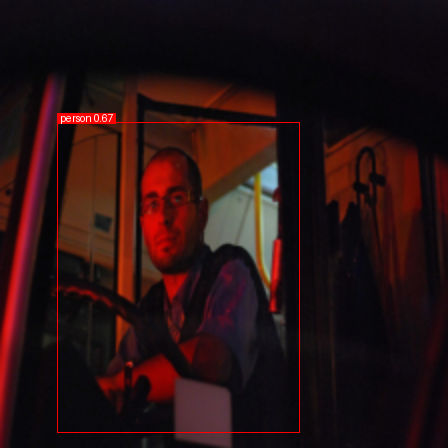

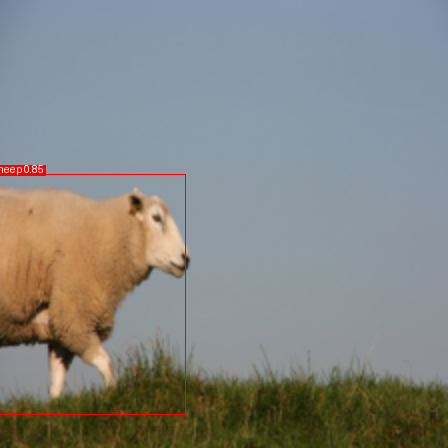

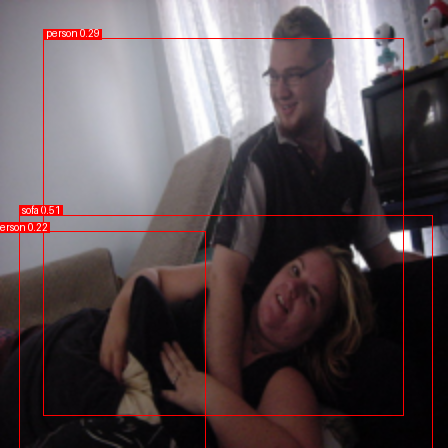

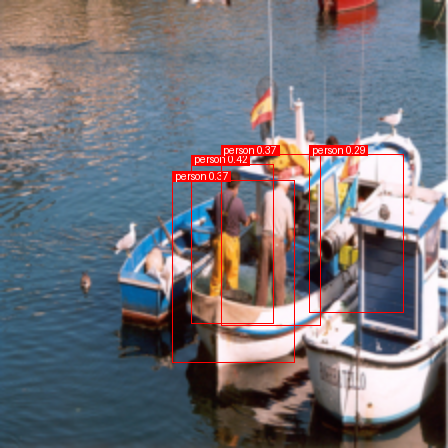

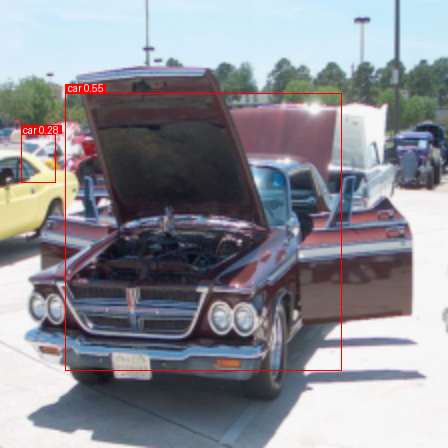

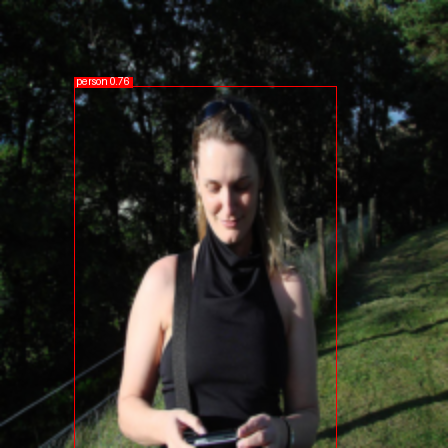

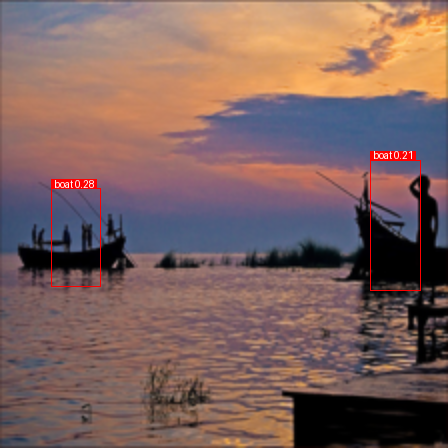

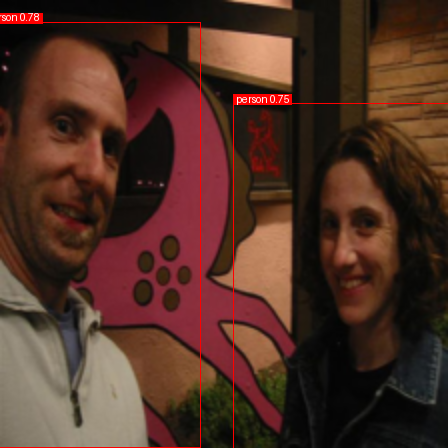

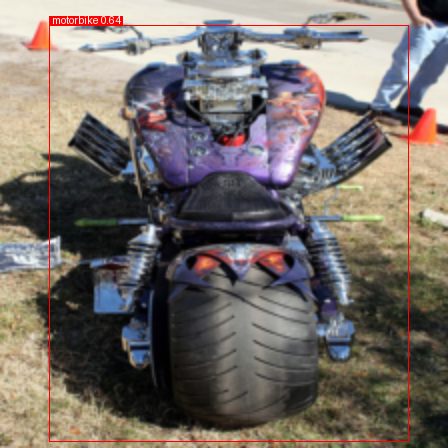

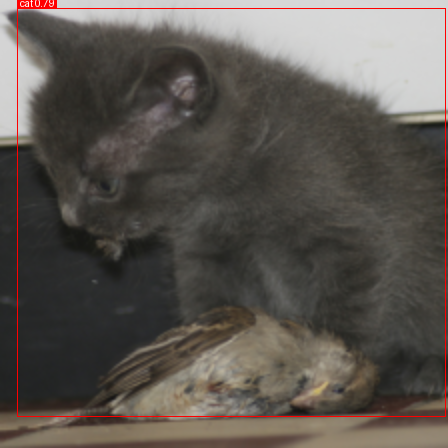

In [ ]:
vli = iter(val_loader)

for _ in range(10):
    nms_visualize(yolonet, next(vli))

# Part 4: Autograder and Submission

After you feel confident that you have a decent model, run the cell below.

Feel free to read the code block but **PLEASE DO NOT TOUCH IT**: this will produce a csv file that will contain your model's predictions on the some subset of samples from the Pascal VOC validation set --- tampering with the code blocks below might mess up the file that you will submit to the Gradescope autograder.

In [ ]:
test_set = torch.utils.data.Subset(val_set, range(1000))
test_batch_size = 64
test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False)

In [ ]:
cell_size = image_size / S

labels = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
          'bus', 'car', 'cat', 'chair', 'cow',
          'diningtable', 'dog', 'horse', 'motorbike', 'person',
          'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [ ]:
if os.path.isfile("YOLO_predictions.csv"):
    os.remove("YOLO_predictions.csv")

yolonet.eval()
with open("YOLO_predictions.csv", "w") as f:
    f.write(f"data_num,class_label,class_num,x1,y1,x2,y2\n")
    for i, batch in enumerate(test_loader):
        imgs, _ = batch
        imgs = imgs.to(device)
        with torch.no_grad():
            preds = yolonet(imgs)

        for j, pred in enumerate(preds):
            boxes_ls, scores_ls, class_label_ls, class_num_ls = [], [], [], []
            for sy in range(S):
                for sx in range(S):
                    cell = pred[sy][sx]
                    for b in range(B):
                        if cell[5 * b] > conf_threshold:
                            cell_size = image_size / S

                            class_num = torch.argmax(cell[5*B:])
                            class_label = labels[class_num]
                            class_num_ls.append(class_num)
                            class_label_ls.append(class_label)

                            y1 = cell_size * (sy + cell[5 * b + 2]) - (image_size * cell[5 * b + 4] / 2)
                            x1 = cell_size * (sx + cell[5 * b + 1]) - (image_size * cell[5 * b + 3] / 2)
                            y2 = y1 + image_size * cell[5 * b + 4]
                            x2 = x1 + image_size * cell[5 * b + 3]

                            xyxy = [x1, y1, x2, y2]

                            scores_ls.append(cell[5 * b])
                            boxes_ls.append(xyxy)

            boxes_ls, scores_ls = torch.tensor(boxes_ls), torch.tensor(scores_ls)
            if len(boxes_ls) == 0:
                continue
            filtered_preds = torchvision.ops.nms(boxes_ls, scores_ls, nms_threshold)
            for idx in filtered_preds:
                x1, y1, x2, y2 = boxes_ls[idx]
                class_label, class_num = class_label_ls[idx], class_num_ls[idx]
                f.write(f"{i*test_batch_size + j}, {class_label}, {class_num}, {x1}, {y1}, {x2}, {y2} \n")

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
